In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 2: Import necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


In [ ]:
# Step 3: Load the CSV file for classification metadata
csv_path = '/content/drive/MyDrive/Shared/LITS 2024 Dec/0to110.csv'
metadata = pd.read_csv(csv_path)

In [ ]:
# Step 4: Optimize data pipeline with tf.data
def load_image_and_mask(row, image_folder, mask_folder, target_size=(256, 256)):
    image_path = os.path.join(image_folder, row['filepath'])
    mask_path = os.path.join(mask_folder, row['liver_maskpath']+'.png')
    # Convert grayscale to 3-channel RGB for MobileNetV2 compatibility
    image = tf.keras.preprocessing.image.load_img(image_path, color_mode='rgb', target_size=target_size)
    mask = tf.keras.preprocessing.image.load_img(mask_path, color_mode='grayscale', target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    mask = tf.keras.preprocessing.image.img_to_array(mask) / 255.0
    return image, mask

In [ ]:
def tf_data_generator(metadata, image_folder, mask_folder, batch_size, target_size=(256, 256)):
    def gen():
        for _, row in metadata.iterrows():
            yield load_image_and_mask(row, image_folder, mask_folder, target_size)

    dataset = tf.data.Dataset.from_generator(gen,
                                             output_signature=(
                                                 tf.TensorSpec(shape=target_size + (3,), dtype=tf.float32),  # 3 channels for input image
                                                 tf.TensorSpec(shape=target_size + (1,), dtype=tf.float32)))  # 1 channel for mask
    dataset = dataset.cache().shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
# Set batch size for the generator
batch_size = 8
image_folder = '/content/drive/MyDrive/Shared/LITS 2024 Dec/Train_CT'
mask_folder = '/content/drive/MyDrive/Shared/LITS 2024 Dec/Train_Mask'
target_size = (224, 224)

In [ ]:
# Split metadata for training and validation
train_file_data, val_file_data = train_test_split(metadata, test_size=0.2, random_state=42)
train_dataset = tf_data_generator(train_file_data, image_folder, mask_folder, batch_size, target_size)
val_dataset = tf_data_generator(val_file_data, image_folder, mask_folder, batch_size, target_size)

In [ ]:
steps_per_epoch = len(train_file_data) // batch_size
validation_steps = len(val_file_data) // batch_size


In [ ]:

def custom_iou(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + tf.keras.backend.epsilon())

In [ ]:
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred > 0.5, tf.float32))
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + tf.keras.backend.epsilon()) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + tf.keras.backend.epsilon())

In [ ]:
def weighted_binary_crossentropy(y_true, y_pred, weight):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return weight * bce


In [ ]:

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [ ]:
def unet_model_with_pretrained_backbone(input_shape):
    inputs = Input(input_shape)
    backbone = MobileNetV2(input_tensor=inputs, include_top=False, weights='imagenet')
    backbone.trainable = False

    # Encoder
    encoder_output = backbone.get_layer('block_13_expand_relu').output

    # Bottleneck
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder_output)

    # Decoder
    up1 = UpSampling2D((2, 2))(bottleneck)
    concat1 = Concatenate()([up1, backbone.get_layer('block_6_expand_relu').output])
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)

    up2 = UpSampling2D((2, 2))(conv3)
    concat2 = Concatenate()([up2, backbone.get_layer('block_3_expand_relu').output])
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)

    # Additional upsampling layers to reach 256x256
    up3 = UpSampling2D((2, 2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3)

    up4 = UpSampling2D((2, 2))(conv5)
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(up4)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv6)
    model = Model(inputs, outputs)
    return model

In [ ]:
# Define input shape dynamically based on target size
input_shape = target_size + (3,)

In [ ]:
segmentation_model = unet_model_with_pretrained_backbone(input_shape)
segmentation_model.compile(optimizer=Adam(learning_rate=1e-4),
                           loss=lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, 2.0),
                           metrics=['accuracy', custom_iou, dice_coefficient])

<ipython-input-21-6e83c63f62df>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = MobileNetV2(input_tensor=inputs, include_top=False, weights='imagenet')


In [ ]:
# Train the segmentation model using the optimized data pipeline
segmentation_history = segmentation_model.fit(
    train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True), lr_scheduler]
)

Epoch 1/20
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 8587s 6s/step - accuracy: 0.9391 - custom_iou: 0.2693 - dice_coefficient: 0.5091 - loss: 0.1909 - val_accuracy: 0.9527 - val_custom_iou: 0.4188 - val_dice_coefficient: 0.7136 - val_loss: 0.1175 - learning_rate: 1.0000e-04
Epoch 2/20
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 1s 138us/step - accuracy: 0.9535 - custom_iou: 0.2657 - dice_coefficient: 0.3932 - loss: 0.1258 - val_accuracy: 0.9194 - val_custom_iou: 0.0021 - val_dice_coefficient: 0.2748 - val_loss: 0.1415 - learning_rate: 1.0000e-04


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Epoch 3/20
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 1543s 991ms/step - accuracy: 0.9535 - custom_iou: 0.4250 - dice_coefficient: 0.7073 - loss: 0.1135 - val_accuracy: 0.9552 - val_custom_iou: 0.4519 - val_dice_coefficient: 0.7496 - val_loss: 0.1007 - learning_rate: 1.0000e-04
Epoch 4/20
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 1s 101us/step - accuracy: 0.9481 - custom_iou: 0.0892 - dice_coefficient: 0.3034 - loss: 0.1038 - val_accuracy: 0.9491 - val_custom_iou: 0.0806 - val_dice_coefficient: 0.0618 - val_loss: 0.1081 - learning_rate: 1.0000e-04
Epoch 5/20
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 1503s 965ms/step - accuracy: 0.9558 - custom_iou: 0.4658 - dice_coefficient: 0.7398 - loss: 0.0984 - val_accuracy: 0.9562 - val_custom_iou: 0.4323 - val_dice_coefficient: 0.7703 - val_loss: 0.0945 - learning_rate: 1.0000e-04
Epoch 6/20
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 1s 115us/step - accuracy: 0.9761 - custom_iou: 0.2001 - dice_coefficient: 0.3929 - loss: 0.0565 - val_accuracy: 0.9949 - val_custom_iou: 0.4671 - val_dice_coeff

In [ ]:
# Save the segmentation model
segmentation_model.save('/content/drive/MyDrive/segmentation_modelJanuary27.h5')

In [ ]:
# Step 7: Preprocess classification data
def preprocess_classification_data(metadata):
    images = []
    labels = []
    for index, row in metadata.iterrows():
        image_path = os.path.join('/content/drive/MyDrive/Shared/LITS 2024 Dec/Train_CT', row['filepath'])
        label = row['Malignant/Benign']
        images.append(tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128), color_mode='rgb'))
        labels.append(label)
    images = np.array([tf.keras.preprocessing.image.img_to_array(img) for img in images])
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    return images / 255.0, tf.keras.utils.to_categorical(labels, num_classes=2)


In [ ]:
x_class, y_class = preprocess_classification_data(metadata)
x_train_cls, x_val_cls, y_train_cls, y_val_cls = train_test_split(x_class, y_class, test_size=0.2, random_state=42)


In [ ]:
# Step 8: Define classification model
def classification_model(input_shape):
    inputs = Input(input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

In [ ]:
cls_model = classification_model(x_train_cls.shape[1:])
cls_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
classification_history = cls_model.fit(
    x_train_cls,
    y_train_cls,
    validation_data=(x_val_cls, y_val_cls),
    epochs=20,
    batch_size=16,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True), lr_scheduler]
)


Epoch 1/20
779/779 ━━━━━━━━━━━━━━━━━━━━ 140s 177ms/step - accuracy: 0.6552 - loss: 0.6107 - val_accuracy: 0.8077 - val_loss: 0.3919 - learning_rate: 1.0000e-04
Epoch 2/20
779/779 ━━━━━━━━━━━━━━━━━━━━ 145s 187ms/step - accuracy: 0.9058 - loss: 0.2435 - val_accuracy: 0.9737 - val_loss: 0.0990 - learning_rate: 1.0000e-04
Epoch 3/20
779/779 ━━━━━━━━━━━━━━━━━━━━ 140s 180ms/step - accuracy: 0.9604 - loss: 0.1100 - val_accuracy: 0.9862 - val_loss: 0.0554 - learning_rate: 1.0000e-04
Epoch 4/20
779/779 ━━━━━━━━━━━━━━━━━━━━ 139s 179ms/step - accuracy: 0.9762 - loss: 0.0624 - val_accuracy: 0.9923 - val_loss: 0.0257 - learning_rate: 1.0000e-04
Epoch 5/20
779/779 ━━━━━━━━━━━━━━━━━━━━ 139s 178ms/step - accuracy: 0.9834 - loss: 0.0464 - val_accuracy: 0.9974 - val_loss: 0.0129 - learning_rate: 1.0000e-04
Epoch 6/20
779/779 ━━━━━━━━━━━━━━━━━━━━ 136s 175ms/step - accuracy: 0.9897 - loss: 0.0304 - val_accuracy: 0.9994 - val_loss: 0.0077 - learning_rate: 1.0000e-04
Epoch 7/20
779/779 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Save the classification model
cls_model.save('/content/drive/MyDrive/classification_modelJanuary27.h5')

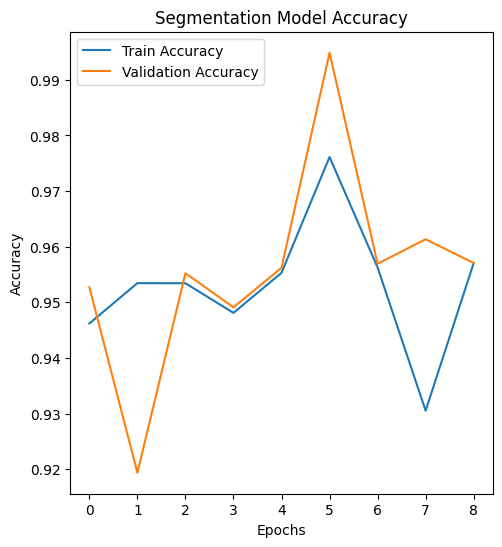

In [ ]:
# Step 9: Plot training and validation metrics
# Segmentation model plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(segmentation_history.history['accuracy'], label='Train Accuracy')
plt.plot(segmentation_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Segmentation Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


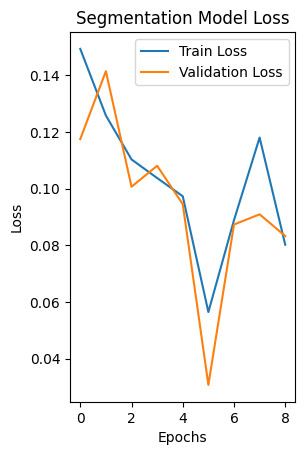

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(segmentation_history.history['loss'], label='Train Loss')
plt.plot(segmentation_history.history['val_loss'], label='Validation Loss')
plt.title('Segmentation Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Classification Model Accuracy')

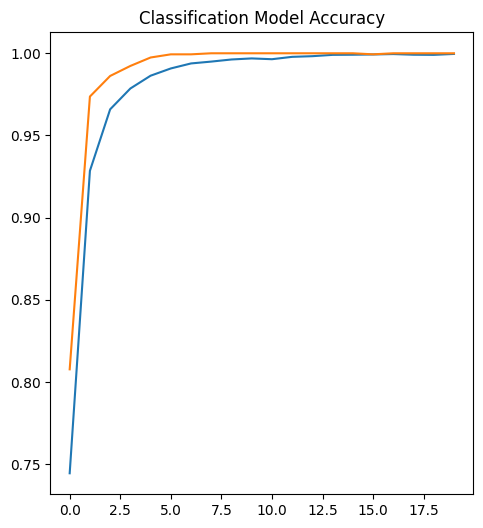

In [ ]:
# Classification model plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(classification_history.history['accuracy'], label='Train Accuracy')
plt.plot(classification_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Classification Model Accuracy')